- modify load_image to eventually add center crop
- add warning of fixed size for ViT and CLIP
- Use CLIP CNN without cosine similarity

In [1]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

# Python native libs
import os
import enum
from collections import namedtuple
import argparse
import numbers
import math


# Deep learning related imports
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
import clip
import open_clip

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt  # visualizations
from PIL import Image

import utils.constants as constants
import utils.utils as utils

In [2]:
import importlib
importlib.reload(utils)
importlib.reload(constants)

from utils.constants import *
from utils.utils import *
import utils.utils as utils

In [23]:
x = "CLIP_"+pretrained[0].upper()
x[5:].lower()

'cc12m'

In [18]:
pretrained = list(np.unique([x[1] for x in open_clip.list_pretrained()]))
for i, x in enumerate(pretrained):
    print(f"    CLIP_{x.upper()} = {i+2}")


    CLIP_CC12M = 2
    CLIP_COMMONPOOL_L_BASIC_S1B_B8K = 3
    CLIP_COMMONPOOL_L_CLIP_S1B_B8K = 4
    CLIP_COMMONPOOL_L_IMAGE_S1B_B8K = 5
    CLIP_COMMONPOOL_L_LAION_S1B_B8K = 6
    CLIP_COMMONPOOL_L_S1B_B8K = 7
    CLIP_COMMONPOOL_L_TEXT_S1B_B8K = 8
    CLIP_COMMONPOOL_M_BASIC_S128M_B4K = 9
    CLIP_COMMONPOOL_M_CLIP_S128M_B4K = 10
    CLIP_COMMONPOOL_M_IMAGE_S128M_B4K = 11
    CLIP_COMMONPOOL_M_LAION_S128M_B4K = 12
    CLIP_COMMONPOOL_M_S128M_B4K = 13
    CLIP_COMMONPOOL_M_TEXT_S128M_B4K = 14
    CLIP_COMMONPOOL_S_BASIC_S13M_B4K = 15
    CLIP_COMMONPOOL_S_CLIP_S13M_B4K = 16
    CLIP_COMMONPOOL_S_IMAGE_S13M_B4K = 17
    CLIP_COMMONPOOL_S_LAION_S13M_B4K = 18
    CLIP_COMMONPOOL_S_S13M_B4K = 19
    CLIP_COMMONPOOL_S_TEXT_S13M_B4K = 20
    CLIP_COMMONPOOL_XL_CLIP_S13B_B90K = 21
    CLIP_COMMONPOOL_XL_LAION_S13B_B90K = 22
    CLIP_COMMONPOOL_XL_S13B_B90K = 23
    CLIP_DATACOMP_L_S1B_B8K = 24
    CLIP_DATACOMP_M_S128M_B4K = 25
    CLIP_DATACOMP_S_S13M_B4K = 26
    CLIP_DATACOMP_XL_S13B_B90

## smongolo

In [49]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)

image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
text = clip.tokenize(["two robots", "three robots"]).to(device)

with torch.no_grad():
    #image_features = model.encode_image(image)
    #text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", logits_per_image)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: tensor([[24.6250, 23.1875]], device='cuda:0', dtype=torch.float16)


In [50]:
openai_rn50 = fetch_and_prepare_model("CLIP_RN50", "OPENAI", DEVICE)
openclip_rn50 = fetch_and_prepare_model("OPENCLIP_RN50", "OPENAI", DEVICE)

In [57]:
input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape = img_dim)
img = pre_process_numpy_img(img)
img = pytorch_input_adapter(img, DEVICE)

img.shape

torch.Size([1, 3, 224, 224])

In [65]:
text = ["cazzo", "barca", "lolo", "robots"]

openai_res = openai_rn50((img, text))
openclip_rn50_res = openclip_rn50((img, text))

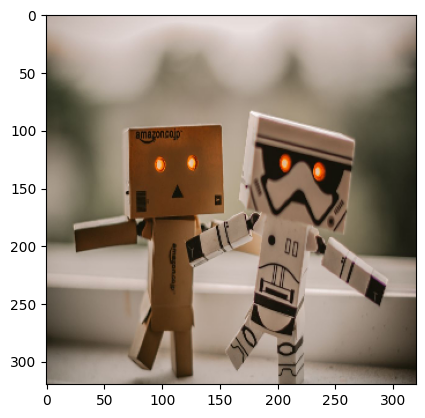

In [89]:
plt.imshow(img)

In [93]:
model_name = "OPENCLIP_CONVNEXT_XXLARGE_320"
model_name = "OPENCLIP_RN50"

weights = "OPENAI"

model = fetch_and_prepare_model(model_name, weights, DEVICE)
input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape = FixedImageResolutions[model_name])
img = pre_process_numpy_img(img)
img = pytorch_input_adapter(img, DEVICE)

text = ["a cat", "two robots", "one robot", "a boat"]
res = model((img ,text))
res

OpenCLIPOutputs(logits_per_image=tensor([[15.4068, 26.5883, 22.7261, 14.1576]], device='cuda:0',
       grad_fn=<MmBackward0>))

In [54]:
open_clip.list_pretrained_tags_by_model("convnext_base_w"), open_clip.list_pretrained_tags_by_model("convnext_base")

(['laion2b_s13b_b82k',
  'laion2b_s13b_b82k_augreg',
  'laion_aesthetic_s13b_b82k'],
 ['laion400m_s13b_b51k'])

In [51]:
model_name = "convnext_base_w"
pretrained = 'laion2b_s13b_b82k_augreg'

model = open_clip.create_model(model_name, pretrained=pretrained, require_pretrained=False).visual

In [24]:
convnextbase = open_clip.create_model("convnext_base")

In [27]:
count_parameters(model), count_parameters(tv_model), count_parameters(convnextbase.visual)

(88221824, 88591464, 88090752)

In [20]:
from torchvision import models

tv_model = models.convnext_base(pretrained=True)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [52]:
count_parameters(convnextbase.visual.trunk), count_parameters(tv_model), count_parameters(model.trunk)

(87566464, 88591464, 87566464)

In [106]:
from torch import Sequential

ImportError: cannot import name 'Sequential' from 'torch' (/home/davide/.venvs/deepdream/lib/python3.8/site-packages/torch/__init__.py)

In [45]:
convnextbase.visual.trunk._modules.keys()

odict_keys(['stem', 'stages', 'norm_pre', 'head'])

In [46]:
tv_model._modules.keys()

odict_keys(['features', 'avgpool', 'classifier'])

In [48]:
model._modules.keys()

odict_keys(['trunk', 'head'])

- features[0] = trunk.stem
- features[1] = trunk.stem.stages[0]
- features[2,3] = trunk.stem.stages[1]
- features[4,5] = trunk.stem.stages[2]
- features[6,7] = trunk.stem.stages[3]

In [30]:
tot = 0
for i, layer in enumerate(tv_model.features):
    print(i, count_parameters(layer))
    tot += count_parameters(layer)
print("tot", tot)

0 6528
1 415488
2 131584
3 1617408
4 525312
5 57424896
6 2099200
7 25344000
tot 87564416


In [38]:
model = convnextbase.visual

tot = 0
print("-1", count_parameters(model.trunk.stem))
tot += count_parameters(model.trunk.stem)
for i, layer in enumerate(model.trunk.stages):
    print(i, count_parameters(layer))
    tot += count_parameters(layer)

print("tot", tot)
    

-1 6528
0 415488
1 1748992
2 57950208
3 27443200
tot 87564416


In [112]:
open_clip.list_pretrained_tags_by_model("convnext_base")

['laion400m_s13b_b51k']

In [ ]:
model = fetch_and_prepare_model("CLIP_RN50", )

In [10]:
SupportedPretrainedWeights.IMAGENET.name == "IMAGENET"

True

In [3]:
model = fetch_and_prepare_model("CONVNEXT_BASE", SupportedPretrainedWeights.IMAGENET.name, DEVICE)

/home/davide/.venvs/deepdream/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/davide/.venvs/deepdream/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
next(model.layers[0].parameters()).to(DEVICE).dtype

torch.float32

In [22]:
model.model.visual

VisionTransformer(
  (patchnorm_pre_ln): Identity()
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [14]:
model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w_320', pretrained='laion_aesthetic_s13b_b82k_augreg')
tokenizer = open_clip.get_tokenizer('convnext_base_w_320')

In [12]:
image = preprocess(Image.open(img_path)).unsqueeze(0)
text = tokenizer(["a diagram", "a dog", "a cat"])

In [15]:
preprocess

Compose(
    Resize(size=320, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(320, 320))
    <function _convert_to_rgb at 0x7fd282209ee0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Some utils

In [2]:
from utils.constants import *
from utils.utils import *
from deepdream import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU

class SupportedModels(enum.Enum):
    VGG16 = 0
    VGG16_EXPERIMENTAL = 1
    GOOGLENET = 2
    RESNET50 = 3
    ALEXNET = 4
    VIT = 5
    CLIPVITB32 = 6
    CLIPVITB16 = 7
    CLIPVITL14 = 8
    CLIPVITL14_336 = 9
    CLIPRN50 = 10
    CLIPRN101 = 11
    CLIPRN50x4 = 12
    CLIPRN50x16 = 13
    CLIPRN50x64 = 14
    

def fetch_and_prepare_model(model_type, pretrained_weights, device):
    if model_type == SupportedModels.VGG16.name:
        model = Vgg16(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.VGG16_EXPERIMENTAL.name:
        model = Vgg16Experimental(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.GOOGLENET.name:
        model = GoogLeNet(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.RESNET50.name:
        model = ResNet50(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.ALEXNET.name:
        model = AlexNet(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.VIT.name:
        model = ViT(pretrained_weights, requires_grad=False, show_progress=True).to(device)
    elif model_type == SupportedModels.CLIPVITB32.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "ViT-B/32").to(device)
    elif model_type == SupportedModels.CLIPVITB16.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "ViT-B/16").to(device)
    elif model_type == SupportedModels.CLIPVITL14.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "ViT-L/14").to(device)
    elif model_type == SupportedModels.CLIPVITL14_336.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "ViT-L/14@336px").to(device)
    elif model_type == SupportedModels.CLIPRN50.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "RN50").to(device)
    elif model_type == SupportedModels.CLIPRN101.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "RN101").to(device)
    elif model_type == SupportedModels.CLIPRN50x4.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "RN50x4").to(device)
    elif model_type == SupportedModels.CLIPRN50x16.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "RN50x16").to(device)
    elif model_type == SupportedModels.CLIPRN50x64.name:
        model = CLIP(requires_grad = False, show_progress = True, checkpoint = "RN50x64").to(device)
    else:
        raise Exception('Model not yet supported.')
    return model



## Dream

In [23]:
# loss.backward(layer) <- original implementation did it like this it's equivalent to MSE(reduction='sum')/2
def gradient_ascent(config, model, input_tensor, input_text, layer_ids_to_use, iteration):
    # Step 0: Feed forward pass
    if model.__class__.__name__ == "CLIP":
        out = model((input_tensor, input_text))
    else:
        out = model(input_tensor)

    # Step 1: Grab activations/feature maps of interest
    activations = [out[layer_id_to_use] for layer_id_to_use in layer_ids_to_use]

    # Step 2: Calculate loss over activations
    losses = []
    for layer_activation in activations:
        # Use torch.norm(torch.flatten(layer_activation), p) with p=2 for L2 loss and p=1 for L1 loss.
        # But I'll use the MSE as it works really good, I didn't notice any serious change when going to L1/L2.
        # using torch.zeros_like as if we wanted to make activations as small as possible but we'll do gradient ascent
        # and that will cause it to actually amplify whatever the network "sees" thus yielding the famous DeepDream look
        loss_component = torch.nn.MSELoss(reduction='mean')(layer_activation, torch.zeros_like(layer_activation))
        losses.append(loss_component)

    loss = torch.mean(torch.stack(losses))
    loss.backward()

    # Step 3: Process image gradients (smoothing + normalization)
    grad = input_tensor.grad.data

    # Applies 3 Gaussian kernels and thus "blurs" or smoothens the gradients and gives visually more pleasing results
    # sigma is calculated using an arbitrary heuristic feel free to experiment
    sigma = ((iteration + 1) / config['num_gradient_ascent_iterations']) * 2.0 + config['smoothing_coefficient']
    smooth_grad = utils.CascadeGaussianSmoothing(kernel_size=9, sigma=sigma)(grad)  # "magic number" 9 just works well

    # Normalize the gradients (make them have mean = 0 and std = 1)
    # I didn't notice any big difference normalizing the mean as well - feel free to experiment
    g_std = torch.std(smooth_grad)
    g_mean = torch.mean(smooth_grad)
    smooth_grad = smooth_grad - g_mean
    smooth_grad = smooth_grad / g_std

    # Step 4: Update image using the calculated gradients (gradient ascent step)
    input_tensor.data += config['lr'] * smooth_grad

    # Step 5: Clear gradients and clamp the data (otherwise values would explode to +- "infinity")
    input_tensor.grad.data.zero_()
    input_tensor.data = torch.max(torch.min(input_tensor, ConstantsContext.UPPER_IMAGE_BOUND), ConstantsContext.LOWER_IMAGE_BOUND)


def deep_dream_static_image(config, img=None):
    model = fetch_and_prepare_model(config['model_name'], config['pretrained_weights'], DEVICE)

    try:
        layer_ids_to_use = [model.layer_names.index(layer_name) for layer_name in config['layers_to_use']]
    except Exception as e:  # making sure you set the correct layer name for this specific model
        print(f'Invalid layer names {[layer_name for layer_name in config["layers_to_use"]]}.')
        print(f'Available layers for model {config["model_name"]} are {model.layer_names}.')
        return

    if img is None:  # load either the provided image or start from a pure noise image
        img_path = os.path.join(INPUT_DATA_PATH, config['input'])
        # load a numpy, [0, 1] range, channel-last, RGB image
        img = load_image(img_path, target_shape=config['img_width'])
        if config['use_noise']:
            shape = img.shape
            img = np.random.uniform(low=0.0, high=1.0, size=shape).astype(np.float32)

    img = pre_process_numpy_img(img)
    original_shape = img.shape[:-1]  # save initial height and width

    input_text = config["text_prompt"]

    print("====")
    print(model.__class__.__name__)

    # Note: simply rescaling the whole result (and not only details, see original implementation) gave me better results
    # Going from smaller to bigger resolution (from pyramid top to bottom)
    for pyramid_level in range(config['pyramid_size']):
        new_shape = get_new_shape(config, original_shape, pyramid_level)
        img = cv.resize(img, (new_shape[1], new_shape[0]))  # resize depending on the current pyramid level
        img = pad_image_to_shape(img, original_shape)
        input_tensor = pytorch_input_adapter(img, DEVICE)  # convert to trainable tensor

        print("======")
        print(f"pyramid_level = {pyramid_level}")
        print(f"new_shape = {new_shape, input_tensor.shape}")
        
        for iteration in range(config['num_gradient_ascent_iterations']):
            
            # Introduce some randomness, it will give us more diverse results especially when you're making videos
            h_shift, w_shift = np.random.randint(-config['spatial_shift_size'], config['spatial_shift_size'] + 1, 2)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift)

            # This is where the magic happens, treat it as a black box until the next cell
            gradient_ascent(config, model, input_tensor, input_text, layer_ids_to_use, iteration)

            # Roll back by the same amount as above (hence should_undo=True)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift, should_undo=True)

        img = pytorch_output_adapter(input_tensor)
        img = extract_original_from_padded(img, new_shape)
        plt.imshow(post_process_numpy_img(img))
        plt.show()
        

    return post_process_numpy_img(img)

## Define models

In [24]:
class ViT(torch.nn.Module):
    def __init__(self, pretrained_weights, requires_grad=False, show_progress=False):

        super().__init__()
        
        if pretrained_weights == SupportedPretrainedWeights.IMAGENET.name:
            vit = models.vit_b_16(pretrained=True, progress = True).eval().to(DEVICE)
        else:
            raise Exception(f'Pretrained weights {pretrained_weights} not yet supported for {self.__class__.__name__} model.')
        
        self.process_input = vit._process_input
        self.class_token = vit.class_token
        self.pos_embedding = vit.encoder.pos_embedding
        
        self.num_layers = 12
        self.layers = vit.encoder.layers

        self.layers_of_interest = [11]
        self.layer_names = ["self_attention", "gelu"]

        # Set these to False so that PyTorch won't be including them in it's autograd engine - eating up precious memory
        if not requires_grad:
          for param in self.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        x = self.process_input(x)
        # N x 196 x 768
        n = x.shape[0]
        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n,-1,-1)
        x = torch.cat([batch_class_token, x], dim=1)
        # N x 197 x 178
        x = x + self.pos_embedding

        for i in range(self.num_layers):
            layer = self.layers[i]
            if i in self.layers_of_interest:
                input = x
                x = layer.ln_1(x)
                x, _ = layer.self_attention(x, x, x, need_weights=False)
                self_attention = x
                x = x + input
        
                y = layer.ln_2(x)
                # 1 x 768
                y = layer.mlp[0](y) ## Linear
                y = layer.mlp[1](y) ## GELU
                # 1 x 3072
                gelu = y
                y = layer.mlp[3](y) ## Linear
                
                x = x + y
            else:
                x = layer(x)
        

        # Feel free to experiment with different layers.
        vit_outputs = namedtuple("ViTOutputs", self.layer_names)
        out = vit_outputs(self_attention, gelu)
        return out

class CLIP(torch.nn.Module):
    def __init__(self, requires_grad=False, show_progress=False, checkpoint="ViT-B/16"):

        super().__init__()

        model, process_image = clip.load(checkpoint, device=DEVICE)
        self.model = model
        self.input_resolution = model.visual.input_resolution
        #self.process_image = process_image
        self.layer_names = ["logits_per_image"]
        
        
        if not requires_grad:
          for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        img, text = x
        # img = self.process_image(img).to(DEVICE)
        img = img.to(DEVICE)
        text = clip.tokenize(text).to(DEVICE)

        logits_per_image, logits_per_text = self.model(img, text)
        out = logits_per_image
        
        # Feel free to experiment with different layers.
        clip_outputs = namedtuple("CLIPOutputs", self.layer_names)
        out = clip_outputs(out)
        return out

    def process_image(self, img_tensor):
        # Ensure img_tensor is a torch tensor
        if not torch.is_tensor(img_tensor):
            raise ValueError("Input image must be a torch tensor")

        # Drop the batch dimension for easier processing
        img_tensor = img_tensor.squeeze(0)

        # Determine the aspect ratio
        _, h, w = img_tensor.shape
        aspect_ratio = w / h

        if aspect_ratio > 1:
            # If width > height, then resize height to self.input_resolution
            new_height = self.input_resolution
            new_width = int(new_height * aspect_ratio)
        else:
            # If width <= height, then resize width to self.input_resolution
            new_width = self.input_resolution
            new_height = int(new_width / aspect_ratio)

        # Resize using torch.nn.functional
        img_tensor = torch.nn.functional.interpolate(img_tensor.unsqueeze(0), size=(new_height, new_width), mode='bicubic', align_corners=True)
        img_tensor = img_tensor.squeeze(0)  # Remove batch dimension

        # Center crop
        target_size = self.input_resolution
        startx = w // 2 - (target_size // 2)
        starty = h // 2 - (target_size // 2)
        img_tensor = img_tensor[:, starty:starty+target_size, startx:startx+target_size]

        # Reshape to [1, 3, w, h]
        img_tensor = img_tensor.unsqueeze(0)

        return img_tensor
        


## Play

In [3]:
import deepdream
import importlib

importlib.reload(deepdream)
importlib.reload(utils)
importlib.reload(constants)

from utils.constants import *
from utils.utils import *
import utils.utils as utils

from deepdream import *

In [4]:
open_clip.list_pretrained_tags_by_model("convnext_base")

['laion400m_s13b_b51k']

In [5]:
open_clip.list_pretrained_tags_by_model(SupportedModel_to_ModelName[SupportedModels.OPENCLIP_COCA_VIT_L_14.name])

['laion2b_s13b_b90k', 'mscoco_finetuned_laion2b_s13b_b90k']

In [26]:
pretrained_weights

'CLIP_LAION_AESTHETIC_S13B_B82K'

In [25]:
model_name = SupportedModels.CONVNEXT_BASE.name
#model_name = SupportedModels.OPENCLIP_CONVNEXT_XXLARGE_320.name
pretrained_weights = 'laion_aesthetic_s13b_b82k'
pretrained_weights = "CLIP_"+pretrained_weights.upper()
#pretrained_weights = "IMAGENET"
layers = ["layer3"]
#img_dim = FixedImageResolutions[model_name]
#img_dim = (224, 224)
img_dim = None

if "CLIP" in pretrained_weights:
    ConstantsContext.use_clip()
else:
    ConstantsContext.use_imagenet()
    
# Only a small subset is exposed by design to avoid cluttering
parser = argparse.ArgumentParser()

# Common params
parser.add_argument("--input", type=str, help="Input IMAGE or VIDEO name that will be used for dreaming", default='figures.jpg')
parser.add_argument("--img_dimensions", type=int, help="Resize input image to this width", default=img_dim)
parser.add_argument("--layers_to_use", type=str, nargs='+', help="Layer whose activations we should maximize while dreaming", default=layers)
parser.add_argument("--text_prompt", type=str, nargs='+', help="Text prompt whose CLIP similaruty we should maximize while dreaming", default="Triangles")
parser.add_argument("--model_name", choices=[m.name for m in SupportedModels],
                    help="Neural network (model) to use for dreaming", default=model_name)
parser.add_argument("--pretrained_weights", choices=[pw.name for pw in SupportedPretrainedWeights],
                    help="Pretrained weights to use for the above model", default=pretrained_weights)

# Main params for experimentation (especially pyramid_size and pyramid_ratio)
parser.add_argument("--pyramid_size", type=int, help="Number of images in an image pyramid", default=4)
parser.add_argument("--pyramid_ratio", type=float, help="Ratio of image sizes in the pyramid", default=2.5)
parser.add_argument("--num_gradient_ascent_iterations", type=int, help="Number of gradient ascent iterations", default=30)
parser.add_argument("--lr", type=float, help="Learning rate i.e. step size in gradient ascent", default=0.09)

# You usually won't need to change these as often
parser.add_argument("--should_display", type=bool, help="Display intermediate dreaming results", default=False)
parser.add_argument("--spatial_shift_size", type=int, help='Number of pixels to randomly shift image before grad ascent', default=2)
parser.add_argument("--smoothing_coefficient", type=float, help='Directly controls standard deviation for gradient smoothing', default=0.5)
parser.add_argument("--use_noise", type=bool, help="Use noise as a starting point instead of input image", default=False)
args = parser.parse_args('')  # important to put '' in Jupyter otherwise it will complain

# Wrapping configuration into a dictionary
config = dict()
for arg in vars(args):
    config[arg] = getattr(args, arg)
config['dump_dir'] = os.path.join(OUT_IMAGES_PATH, f'{config["model_name"]}_{config["pretrained_weights"]}')
config['input'] = os.path.basename(config['input'])  # handle absolute and relative paths

In [10]:
import torchvision

<enum 'ConvNeXt_Base_Weights'>

(800, 1200, 3) (800, 1200, 3)


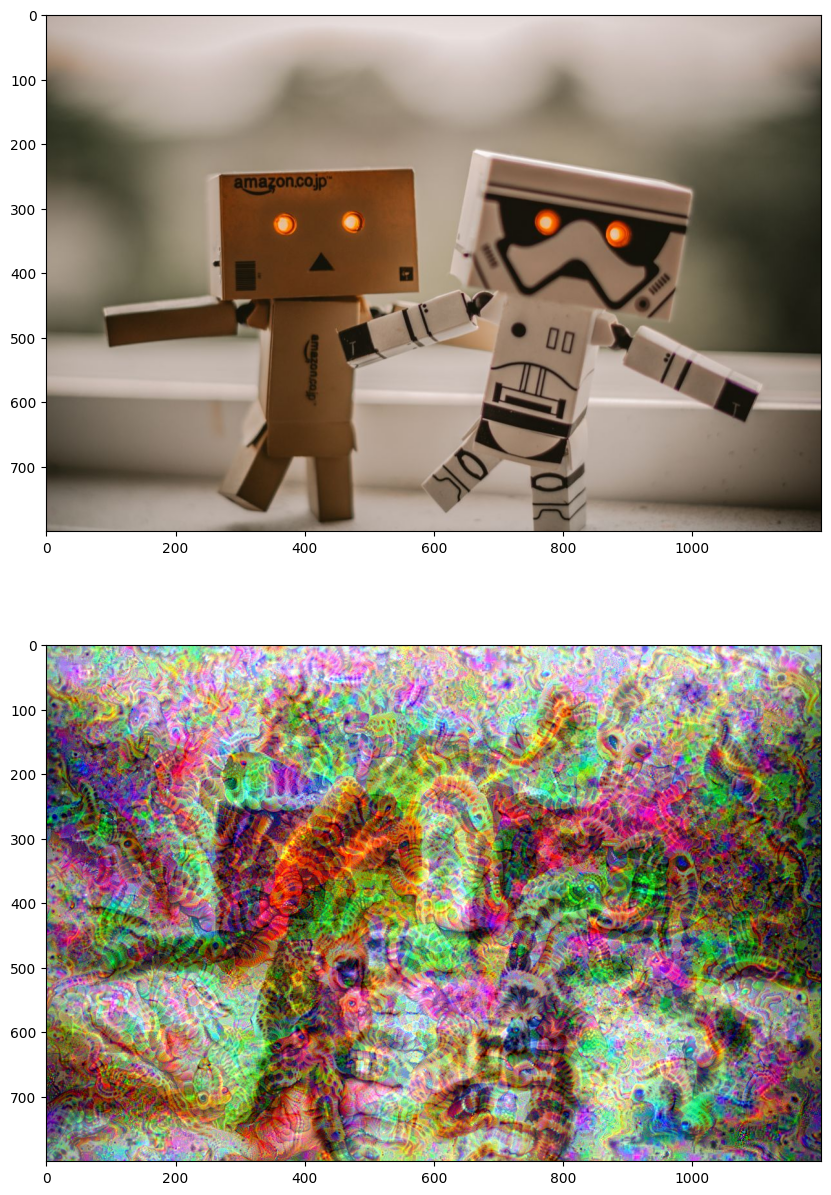

In [6]:
# from deepdream import *

input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape = img_dim)
#img = Image.open(img_path)

dream_img = deep_dream_static_image(config, None)  # yep a single liner

print(img.shape, dream_img.shape)

# plot
fig, axs = plt.subplots(2,1, figsize = (10, 15))
axs[0].imshow(img)
axs[1].imshow(dream_img)
plt.show()

(800, 1200, 3) (800, 1200, 3)


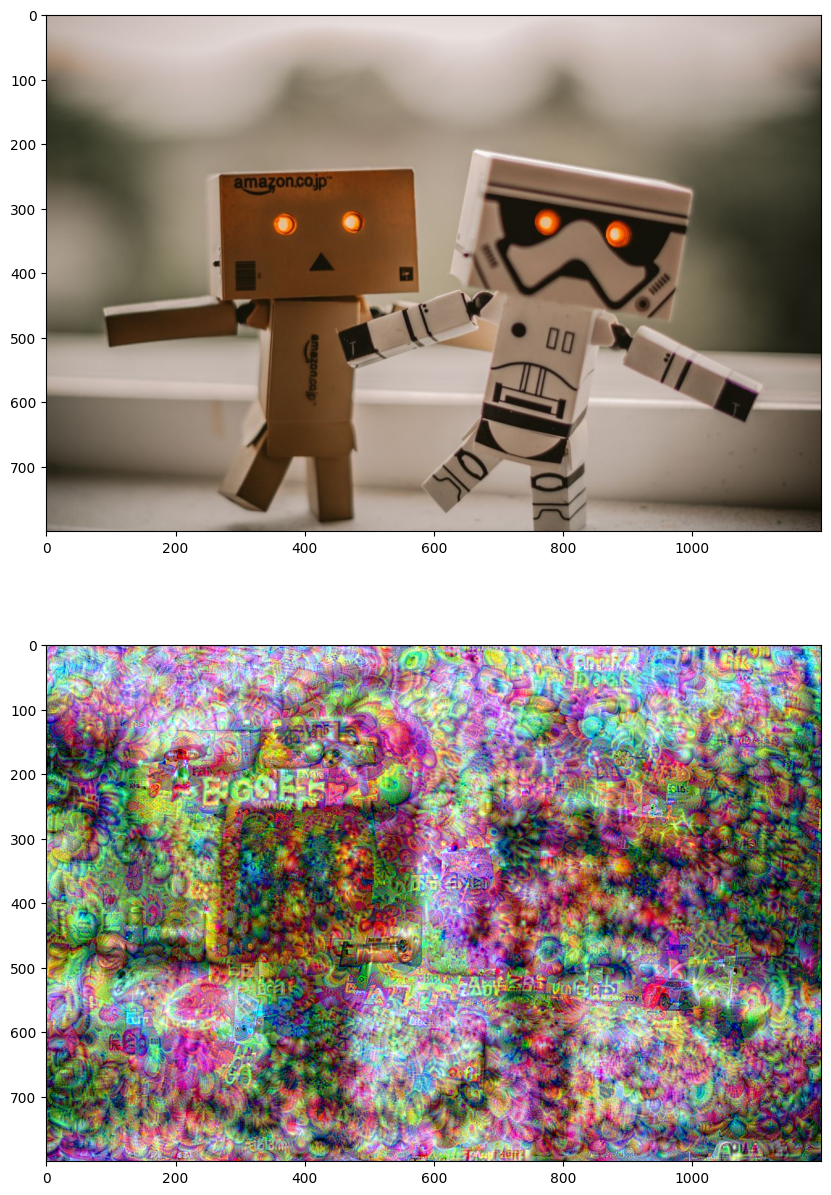

In [8]:
# from deepdream import *

input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape = img_dim)
#img = Image.open(img_path)

dream_img = deep_dream_static_image(config, None)  # yep a single liner

print(img.shape, dream_img.shape)

# plot
fig, axs = plt.subplots(2,1, figsize = (10, 15))
axs[0].imshow(img)
axs[1].imshow(dream_img)
plt.show()

In [37]:
import os 
import cv2
from tqdm import tqdm


# Define the path to the frames and the output video file
frame_folder = "data/out-videos/CONVNEXT_BASE_CLIP_LAION_AESTHETIC_S13B_B82K"
output_video_path = 'data/out-videos/jellyfish_ouroboros.mp4'

# Get all files from the directory
frames = [os.path.join(frame_folder, frame) for frame in os.listdir(frame_folder) if frame.endswith(".jpg")]
frames.sort()  # Ensure frames are in order

# Read the first frame to get height, width
frame = cv2.imread(frames[0])
height, width, _ = frame.shape

# Define codec using VideoWriter_fourcc and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 10.0, (width, height))

# Write each frame to the video
for frame_path in tqdm(frames[:2000]):
    frame = cv2.imread(frame_path)
    out.write(frame)

# Release the VideoWriter
out.release()

print(f"Video saved to {output_video_path}")

100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 26.06it/s]


Video saved to data/out-videos/jellyfish_ouroboros.mp4


In [35]:
output_video_path

'data/out-videos/jellyfish_ouroboros.mp4'

In [38]:
from IPython.display import Video

happily_jellyfishing = 'data/out-videos/output_video.mp4'

# Display the video
Video(output_video_path, width = 700)
